In [1]:
%env CUDA_VISIBLE_DEVICES=''

env: CUDA_VISIBLE_DEVICES=''


In [2]:
from typing import List, Tuple,Dict
import numpy as np
import matplotlib.pyplot as plt
import json
from pprint import pprint

from utils_refactored import FileManager

#### Clean 

In [3]:
import json
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple


def load_ground_truth(path: str) -> Dict[int, List[Dict]]:
    """Load ground truth data from a JSON file."""
    with open(path, 'r') as f:
        data = json.load(f)
    
    ground_truth = {}
    for annotation in data['annotations']:
        image_id = annotation['image_id']
        if image_id not in ground_truth:
            ground_truth[image_id] = []
        ground_truth[image_id].append(annotation)
    
    return ground_truth


def load_detections(path: str) -> Dict[int, List[Dict]]:
    """Load detections data from a JSON file."""
    with open(path, 'r') as f:
        data = json.load(f)
    
    detections = {}
    for det in data:
        image_id = det['image_id']
        if image_id not in detections:
            detections[image_id] = []
        detections[image_id].append(det)
    
    return detections


def calculate_iou(det_box: List[float], gt_box: List[float]) -> float:
    """Calculate Intersection over Union (IoU) for two bounding boxes."""
    det_x1, det_y1, det_width, det_height = det_box
    gt_x1, gt_y1, gt_width, gt_height = gt_box

    det_x2 = det_x1 + det_width
    det_y2 = det_y1 + det_height
    gt_x2 = gt_x1 + gt_width
    gt_y2 = gt_y1 + gt_height

    x1 = max(det_x1, gt_x1)
    y1 = max(det_y1, gt_y1)
    x2 = min(det_x2, gt_x2)
    y2 = min(det_y2, gt_y2)

    intersection = max(0, x2 - x1) * max(0, y2 - y1)
    det_area = det_width * det_height
    gt_area = gt_width * gt_height
    iou = intersection / float(det_area + gt_area - intersection)

    return iou


def evaluate_detections(gt_path: str, dt_path: str, iou_threshold: float = 0.5) -> Tuple[List[float], List[float], List[float]]:
    """Evaluate detections against ground truth data and compute precision and recall."""
    gt_data = load_ground_truth(gt_path)
    dt_data = load_detections(dt_path)

    all_detections = []
    all_gt_counts = sum([len(boxes) for boxes in gt_data.values()])

    for image_id, gt_boxes in gt_data.items():
        dt_boxes = dt_data.get(image_id, [])

        for dt_box in dt_boxes:
            dt_box['image_id'] = image_id
        all_detections.extend(dt_boxes)

    # Sort all detections by score in descending order
    all_detections.sort(key=lambda x: x['score'], reverse=True)

    tps = []
    fps = []
    scores = []

    for dt_box in all_detections:
        image_id = dt_box['image_id']
        gt_boxes = gt_data.get(image_id, [])

        if not gt_boxes:
            fps.append(1)
            tps.append(0)
            scores.append(dt_box['score'])
            continue

        gt_bboxes = [gt_box['bbox'] for gt_box in gt_boxes]

        ious = [calculate_iou(dt_box['bbox'], gt_bbox) for gt_bbox in gt_bboxes]
        max_iou_index = np.argmax(ious)

        if ious[max_iou_index] >= iou_threshold:
            tps.append(1)
            fps.append(0)
            del gt_boxes[max_iou_index]
        else:
            fps.append(1)
            tps.append(0)
        scores.append(dt_box['score'])

    tps = np.array(tps)
    fps = np.array(fps)
    scores = np.array(scores)

    # Accumulate the true positives and false positives
    tps = np.cumsum(tps)
    fps = np.cumsum(fps)

    # Calculate the precision and recall
    precisions = tps / (tps + fps)
    recalls = tps / all_gt_counts

    # Add the (0,1) and (1,0) points to the curve
    #precisions = np.concatenate(([1.0], precisions, [0.0]))
    #recalls = np.concatenate(([0.0], recalls, [1.0]))

    return precisions, recalls, scores

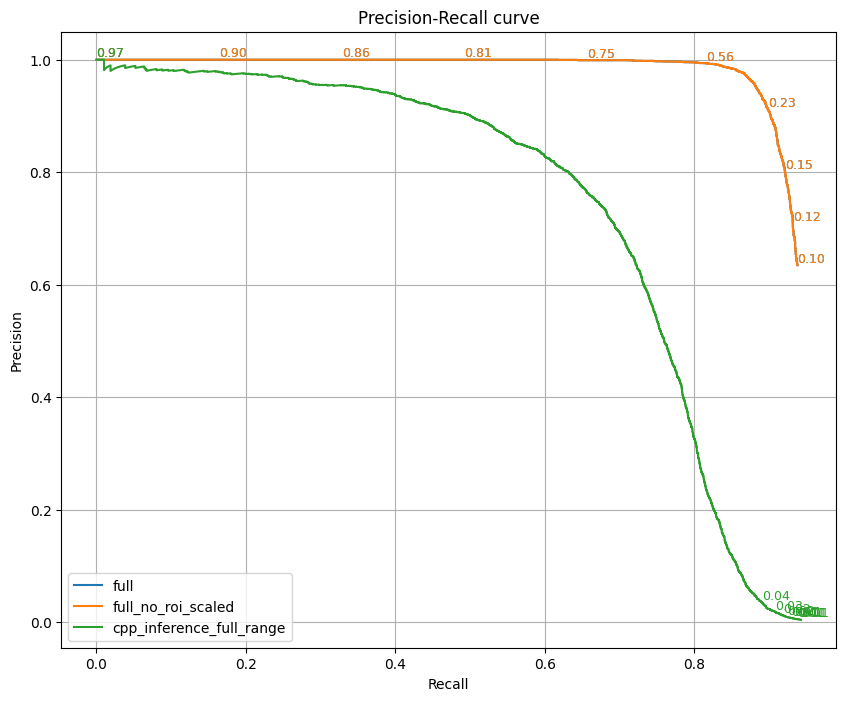

In [4]:
gt_path = './data/coco_ground_truths.json'
dt_paths = {
    #"short": './data/coco_detections_short.json',
    "full": './data/coco_detections_full.json',
    #"TEST": './data/coco_detections_TEST.json',
    #"yolo": './data/coco_detections_yolo.json',
    #"yolo 128": './data/coco_detections_yolo_128.json',
    #"yunet": './data/coco_detections_yunet.json',
    #"full_no_roi": "./data/coco_detections_removed_preprocess.json",
    "full_no_roi_scaled": "./data/coco_detections_removed_preprocess_scaled.json",
    "cpp_inference_full_range": "./data/coco_detections_cpp_inference_full_range.json"
    #"front_mirror": "./data/coco_detections_front_mirror.json"
}

iou_threshold = 0.3

plt.figure(figsize=(10, 8))

for name, dt_path in dt_paths.items():
    precisions, recalls, thresholds = evaluate_detections(gt_path, dt_path, iou_threshold)
    
    # Plot the Precision-Recall curve and get the line object
    line, = plt.plot(recalls, precisions, label=name)

    # Select 10 evenly spaced thresholds to annotate
    selected_indices = np.linspace(0, len(thresholds) - 1, 10, dtype=int)
    selected_thresholds = thresholds[selected_indices]
    selected_recalls = recalls[selected_indices]
    selected_precisions = precisions[selected_indices]

    # Plot the selected thresholds with the color of the line
    for i in range(len(selected_thresholds)):
        plt.text(selected_recalls[i], selected_precisions[i], f'{selected_thresholds[i]:.2f}', 
                 fontsize=9, va='bottom', color=line.get_color())

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.title('Precision-Recall curve')
plt.show()

In [5]:
from sklearn.metrics import auc

# Compute and print AUC for each model
for name, dt_path in dt_paths.items():
    precisions, recalls, thresholds = evaluate_detections(gt_path, dt_path, iou_threshold)
    model_auc = auc(recalls, precisions)
    print(f"AUC for {name}: {model_auc:.3f}")

AUC for full: 0.927
AUC for full_no_roi_scaled: 0.927
AUC for cpp_inference_full_range: 0.711


### make subplots with rois

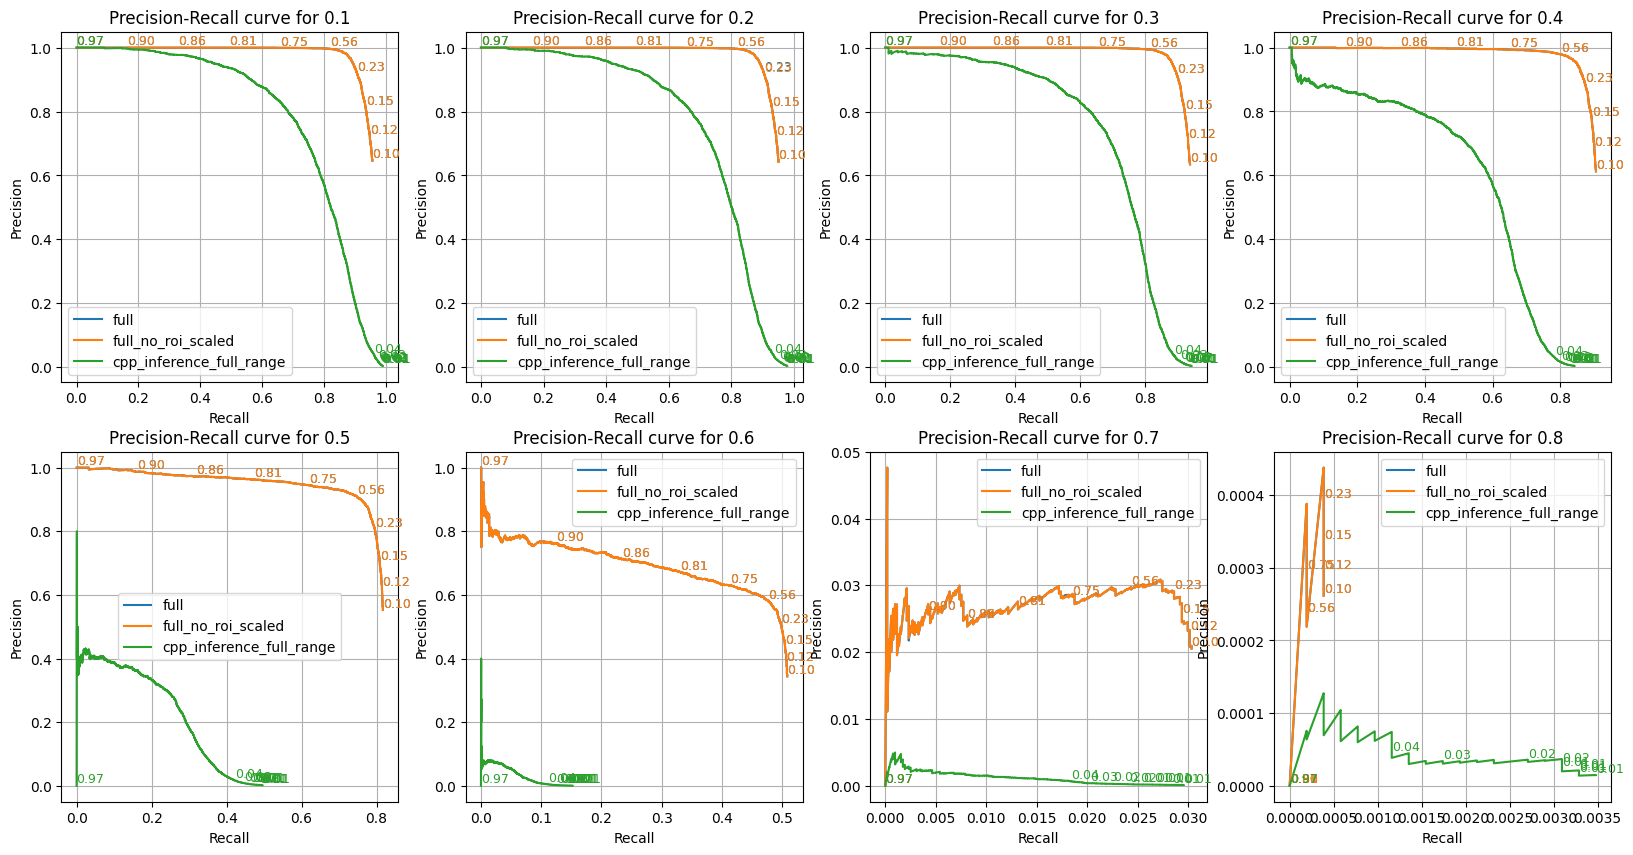

In [6]:
iou_thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]


fig,axs = plt.subplots(2,4,figsize=(20,10))
axs = axs.ravel()
#plt.figure(figsize=(10, 10))
for i,ax in enumerate(axs):
    iou_threshold = iou_thresholds[i]
    for name, dt_path in dt_paths.items():
        precisions, recalls, thresholds = evaluate_detections(gt_path, dt_path, iou_threshold)
        
        # Plot the Precision-Recall curve and get the line object
        line, = ax.plot(recalls, precisions, label=name)

        # Select 10 evenly spaced thresholds to annotate
        selected_indices = np.linspace(0, len(thresholds) - 1, 10, dtype=int)
        selected_thresholds = thresholds[selected_indices]
        selected_recalls = recalls[selected_indices]
        selected_precisions = precisions[selected_indices]

        # Plot the selected thresholds with the color of the line
        for i in range(len(selected_thresholds)):
            ax.text(selected_recalls[i], selected_precisions[i], f'{selected_thresholds[i]:.2f}', 
                    fontsize=9, va='bottom', color=line.get_color())

    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.legend()
    ax.grid(True)
    ax.set_title(f'Precision-Recall curve for {iou_threshold}')
plt.show()